<span style="font-size:25px">
The following methods are existing baseline methods in explainable AI applied to my full_mnist FFN.
</span>

In [13]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter
import random as ra
from captum.attr import LRP

In [6]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16
out_size = 10
epochs = 10
batch_size = 64
learning_rate = 0.001

In [7]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        out = self.tanh(self.fc0(x))
        out = self.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [9]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [10]:
net.load_state_dict(torch.load("ffn_mnist_full.pth"))

<All keys matched successfully>

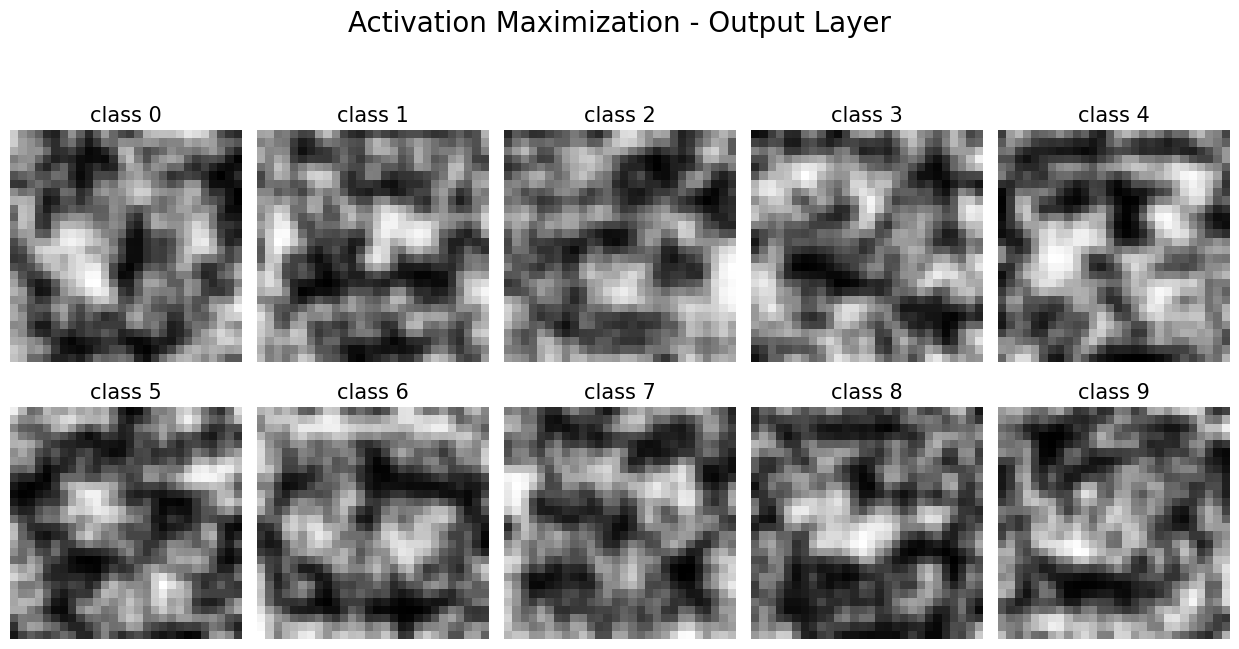

In [67]:
layer_name = "output"
neuron_indices = list(range(10))
steps = 200
lr = 0.1
smoothing_sigma = 0.8

net.eval()
device = 'cuda' if CUDA else 'cpu'
images = []

for idx in neuron_indices:
    input_image = torch.randn(1, 784, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        logits = net(input_image)
        activation = logits[0, idx]
        loss = -activation
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            input_image.clamp_(0, 1)

    img_np = input_image.detach().cpu().view(28, 28).numpy()
    if smoothing_sigma > 0:
        img_np = gaussian_filter(img_np, sigma=smoothing_sigma)
    images.append(img_np)

#plotting

rows = -(-len(images) // 5)
plt.figure(figsize=(5 * 2.5, rows * 3.5))
for i, img in enumerate(images):
    plt.subplot(rows, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'class {neuron_indices[i]}', fontsize=15)
    plt.axis('off')

plt.suptitle(f'Activation Maximization - Output Layer', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

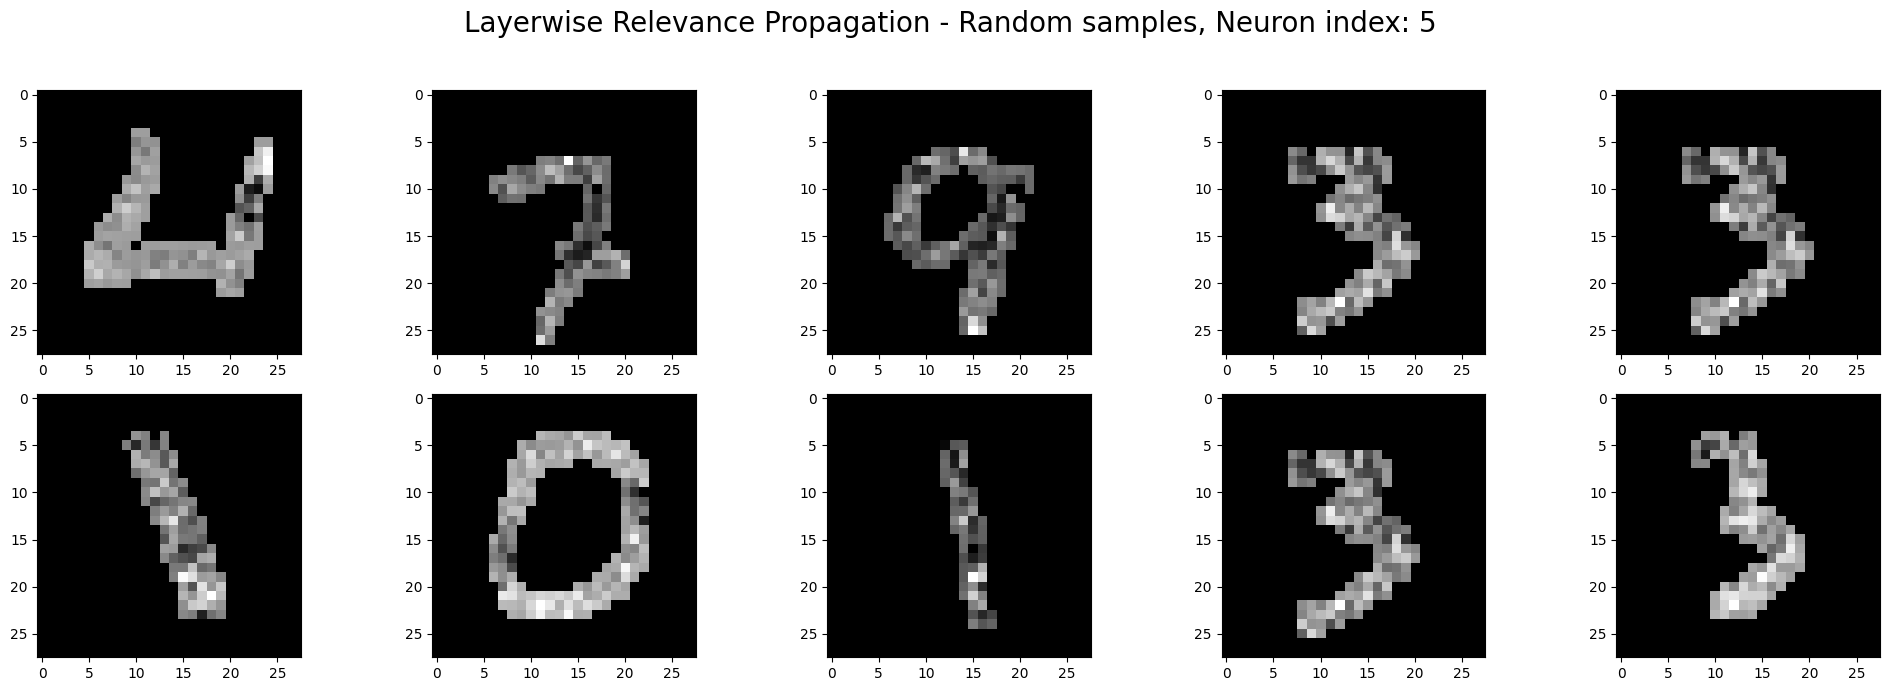

In [66]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))
example_count = 10
target_class = torch.tensor(5).cuda()

plt.figure(figsize=(20, -(-example_count // 5) * 3.5))

for ind in range(example_count):
    ind_rand = ind + ra.randint(0, len(inputs) - 1 - example_count)
    input = inputs[ind_rand].unsqueeze(0)
    input.requires_grad_()
    input = input.cuda()

    lrp = LRP(net)
    attributions = lrp.attribute(input.view(1, 784), target=target_class)
    rel_map = attributions[0].cpu().detach().numpy().reshape(28, 28)

    input = input.cpu().detach().numpy().reshape(28, 28)
    back_ground = (input == 0)
    rel_map[back_ground] = rel_map.min()
    rel_map /= rel_map.max()

    plt.subplot(-(-example_count // 5), 5, ind + 1)
    plt.imshow(rel_map, cmap="gray")
    #plt.axis('off')

plt.suptitle(f'Layerwise Relevance Propagation - Random samples, Neuron index: {target_class}', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<span style="font-size:25px">
Further baseline (existing) methods such as SHAP, LIME, counterfactuals, or surrogate models will not be executed here, but their theoretic limitations discussed later.
The above methods serve as examples for interpretable but limited methods.
Further experiments aimed at further highlighting the limitations in explaining modern AI.
</span>